<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-phoenix-assets/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Hallucination Classification Evals</h1>

The purpose of this notebook is:

- to evaluate the performance of an LLM-assisted approach to detecting hallucinations,
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [1]:
#####################
## N_EVAL_SAMPLE_SIZE
#####################
# Eval sample size determines the run time
# 100 samples: GPT-4 ~ 80 sec / GPT-3.5 ~ 40 sec
# 1,000 samples: GPT-4 ~15-17 min / GPT-3.5 ~ 6-7min (depending on retries)
# 10,000 samples GPT-4 ~170 min / GPT-3.5 ~ 70min
N_EVAL_SAMPLE_SIZE = 100

In [2]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from phoenix.evals import (
    HALLUCINATION_PROMPT_RAILS_MAP,
    HALLUCINATION_PROMPT_TEMPLATE,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the evaluation system consisting of an LLM model and settings in addition to an evaluation prompt template against benchmark datasets of queries and retrieved documents with ground-truth relevance labels. Currently supported datasets include "halueval_qa_data" from the HaluEval benchmark:

- https://arxiv.org/abs/2305.11747
- https://github.com/RUCAIBox/HaluEval

In [5]:
df = download_benchmark_dataset(
    task="binary-hallucination-classification", dataset_name="halueval_qa_data"
)
df.head()

,reference,query,response,is_hallucination
0,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,no,False
1,"() is a prefecture-level city in northwestern Anhui province, China.Gaozhou is a county-level city in southwestern Guangdong Province, China.",Can Fuyang and Gaozhou be found in the same province?,"Yes, Fuyang and Gaozhou are in the same province.",True
2,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"Billboard"" Hot 100",False
3,"""808"" was a success in the United States becoming the group's first top ten hit peaking at number eight on the ""Billboard"" Hot 100 and top five peaking at number four on the Hot R&B/Hip-Hop Singles.The ""Billboard"" Hot 100 is the music industry standard record chart in the United States for singles, published weekly by ""Billboard"" magazine.",808 peaked at number eight on what?,"""808"" peaked at number nine on ""Billboard"" Hot 100.",True
4,"""Arms"" then made a comeback in 2017 reaching #36 on the iTunes chart passing Auli'i Cravalho's ""How Far I'll Go"" from the Disney movie ""Moana"" (2017).Moana ( ) is a 2016 American 3D computer-animated musical fantasy-adventure film produced by Walt Disney Animation Studios and released by Walt Disney Pictures.","Arms is a song by American singer-songwriter Christina Perri, in 2017, it passed Auli'i Cravalho's, ""How Far I'll Go"" from which 2016, American 3D computer-animated Disney movie?",Moana,False


## Display Binary Hallucination Classification Template

View the default template used to classify hallucinations. You can tweak this template and evaluate its performance relative to the default.

In [6]:
print(HALLUCINATION_PROMPT_TEMPLATE)


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text. Your response should be a single word: either "factual" or "hallucinated", and
it should not include any other text or characters. "hallucinated" indicates that the answer
provides factually inaccurate information to the query based on the reference text. "factual"
indicates that the answer to the question is correct relative to the reference text, and does not
contain made up inf

Template variables:
- **input** : The question or prompt asked on the context data.
- **reference** : The context data used to answer the question
- **output** : The answer generated from the context data, we are checking this answer for halluciations relative to the reference context

## Configure the LLM

Configure your OpenAI API key.

In [7]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
openai.api_key = openai_api_key
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

In [8]:
df = (
    df.sample(n=N_EVAL_SAMPLE_SIZE)
    .reset_index(drop=True)
    .rename(columns={"query": "input", "response": "output"})
)

## LLM Evals: hallucination Classifications GPT-4
Run hallucination against a subset of the data.

Instantiate the LLM and set parameters.

In [9]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [10]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

In [11]:
# The rails fore the output to specific values of the template
# It will remove text such as ",,," or "...", anything not the
# binary value expected from the template
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails, concurrency=20
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

Worker timeout, requeuing




Evaluate the predictions against human-labeled ground-truth hallucination labels.

              precision    recall  f1-score   support

hallucinated       0.97      0.75      0.85        48
     factual       0.81      0.98      0.89        52

    accuracy                           0.87       100
   macro avg       0.89      0.87      0.87       100
weighted avg       0.89      0.87      0.87       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

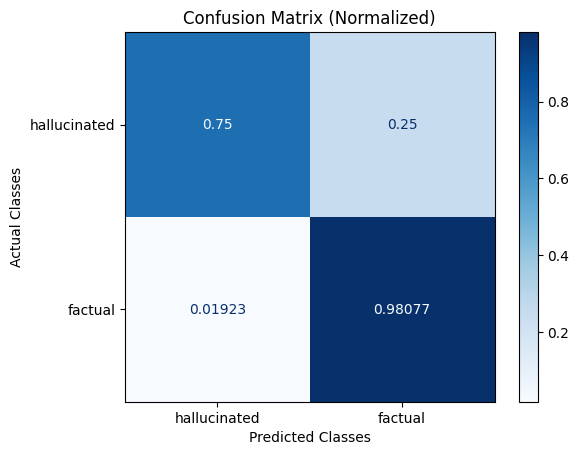

In [12]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for hallucinations, it can be useful to know why the LLM classified a response as a hallucination or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [13]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
hallucination_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


In this task, you will be presented with a query, a reference text and an answer. The answer is
generated to the question based on the reference text. The answer may contain false information, you
must use the reference text to determine if the answer to the question contains false information,
if the answer is a hallucination of facts. Your objective is to determine whether the reference text
contains factual information and is not a hallucination. A 'hallucination' in this context refers to
an answer that is not based on the reference text or assumes information that is not available in
the reference text.

    [BEGIN DATA]
    ************
    [Query]: {input}
    ************
    [Reference text]: {reference}
    ************
    [Answer]: {output}
    ************
    [END DATA]

    Is the answer above factual or hallucinated based on the query and reference text?

Please read the query, reference text and answer carefully, then write out in a step by step manner


llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'factual' to rail: factual
- Snapped 'factual' to rail: factual
- Snapped 'factual' to rail: factual
- Snapped 'factual' to rail: factual
- Snapped 'hallucinated' to rail: hallucinated


In [14]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, hallucination_classifications_df, left_index=True, right_index=True
)
merged_df[["input", "reference", "output", "is_hallucination", "label", "explanation"]].head()

,input,reference,output,is_hallucination,label,explanation
0,What does Georges Méliès and Alexander Kluge have in common?,"Marie-Georges-Jean Méliès, known as Georges Méliès ( ; ] ; 8 December 1861 – 21 January 1938), was a French illusionist and film director who led many technical and narrative developments in the earliest days of cinema.Alexander Kluge (born 14 February 1932) is a German author, philosopher, academic and film director.",film director.,False,factual,"The query asks what Georges Méliès and Alexander Kluge have in common. The reference text states that Georges Méliès was a French illusionist and film director, and Alexander Kluge is a German author, philosopher, academic and film director. The commonality between them, as stated in the reference text, is that they are both film directors. Therefore, the answer 'film director' is based on the information provided in the reference text."
1,Who was the mother of the woman who made the Star Spangled banner flag hoisted over a city that was designated a national park in 1925?,"Mary Pickersgill (born Mary Young; February 12, 1776 – October 4, 1857), was the maker of the Star Spangled Banner Flag hoisted over Fort McHenry during the Battle of Baltimore in the War of 1812. The daughter of another noted flag maker, Rebecca Young, Pickersgill learned her craft from her mother, and, in 1813, was commissioned by Major George Armistead to make a flag for Baltimore's Fort McHenry that was so large that the British would have no difficulty seeing it from a great distance.Fort McHenry, in Baltimore, Maryland, is a historical American coastal pentagonal bastion fort best known for its role in the War of 1812, when it successfully defended Baltimore Harbor from an attack by the British navy from the Chesapeake Bay September 13–14, 1814.",Rebecca Young,False,factual,"The query asks for the mother of Mary Pickersgill, the woman who made the Star Spangled Banner flag. The reference text clearly states that Mary Pickersgill's mother is Rebecca Young. Therefore, the answer 'Rebecca Young' is based on the information provided in the reference text and is factual."
2,What is the name of the soap opera with the character Tasha Andrews?,"Natasha ""Tasha"" Hunter (also Andrews) is a fictional character from the Australian soap opera ""Home and Away"", played by Isabel Lucas.Isabel Lucas (born 29 January 1985) is an Australian actress, and model. She is best known for her roles in ""Home and Away"" (2003–2006), """" (2009), ""Daybreakers"" (2009), ""The Pacific"" (2010), ""Immortals"" (2011), and ""Red Dawn"" (2012).","""Home and Away""",False,factual,"The query asks for the name of the soap opera that features the character Tasha Andrews. The reference text clearly states that Tasha Andrews is a character from the Australian soap opera 'Home and Away'. The answer provided is 'Home and Away', which matches the information given in the reference text. Therefore, the answer is based on the reference text and does not assume any information that is not available in the reference text."
3,"Ettore or Edoardo Ettore Forti was an Italian painter, who was prolific in depicting realistic Neo-Pompeian scenes of Ancient Roman life and events, these subjects were popular in the late-Victorian period, as exemplified by the popularity of Lawrence Alma-Tadema, born in Dronrijp, in which country?","These subjects were popular in the late-Victorian period, as exemplified by the popularity of Lawrence Alma-Tadema, as an example. Born in Dronrijp, the Netherlands, and trained at the Royal Academy of Antwerp, Belgium, he settled in England in 1870 and spent the rest of his life there.",Ettore Forti was an Italian painter.,True,hallucinated,"The answer states that 'Ettore Forti was an Italian painter.' However, the query is asking about the birthplace of Lawrence Alma-Tadema, not about Ettore Forti. The reference text provides information about Lawrence Alma-Tadema being born in Dronrijp, the Netherlands. The

## LLM Evals: hallucination Classifications GPT-3.5
Run hallucination against a subset of the data.

In [15]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


In [16]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df, template=HALLUCINATION_PROMPT_TEMPLATE, model=model, rails=rails, concurrency=20
)["label"].tolist()

llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

hallucinated       0.82      0.75      0.78        48
     factual       0.79      0.85      0.81        52

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

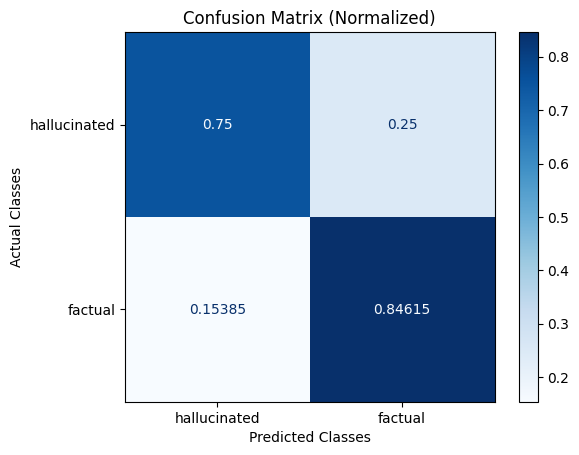

In [17]:
true_labels = df["is_hallucination"].map(HALLUCINATION_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

# Preview: GPT-4 Turbo

In [18]:
rails = list(HALLUCINATION_PROMPT_RAILS_MAP.values())
hallucination_classifications = llm_classify(
    dataframe=df,
    template=HALLUCINATION_PROMPT_TEMPLATE,
    model=OpenAIModel(model_name="gpt-4-turbo-preview", temperature=0.0),
    rails=rails,
    concurrency=20,
)["label"].tolist()

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_classify |          | 0/100 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

hallucinated       0.94      0.71      0.81        48
     factual       0.78      0.96      0.86        52

    accuracy                           0.84       100
   macro avg       0.86      0.83      0.84       100
weighted avg       0.86      0.84      0.84       100



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

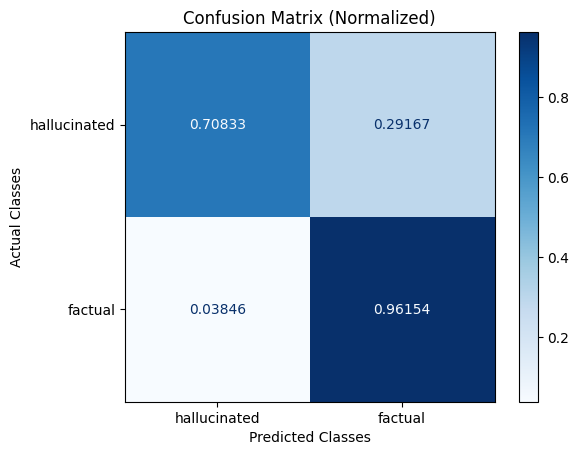

In [19]:
print(classification_report(true_labels, hallucination_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels,
    predict_vector=hallucination_classifications,
    classes=rails,
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)